In [1]:
import os
import subprocess
import time

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd

#go to working directory
#work_dir='/nagyvinyok/adat84/sotejedlik/ribli/mhc'
work_dir='/mnt/Data1/ribli/mhc/'
subprocess.call(['mkdir',work_dir])
os.chdir(work_dir)

In [2]:
#load train data
dataf='benchmark_mhci_reliability/binding/bd2013.1/bdata.20130222.mhci.public.1.txt'
data=pd.read_csv(dataf,sep='\t')
data=data[(data.species=='human') &(data.inequality=='=') ][['mhc','sequence','meas','peptide_length']]
len(data)

83751

### Use the most simplistic encoding

In [3]:
#make peptids 'equal'
maxlen=max(data.peptide_length.values)
data['sequence']=[x.zfill(maxlen) for x in data.sequence.values]

from sklearn import preprocessing
lb = preprocessing.LabelEncoder()

#just encode hla type with integers
x_hla=lb.fit_transform( data.mhc )

#just encode them with their ascii number
x_seq=np.array([map(ord,x) for x in data.sequence])

#stack the two and peptid length together
x=np.column_stack([x_hla,x_seq,data.peptide_length.values])

In [4]:
#predict log10 value
y=np.log10(data.meas)

In [5]:
#make train, test and validation split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

In [6]:
import xgboost as xgb

#data format for xgb
dtrain = xgb.DMatrix( X_train, label=y_train)
dvalid = xgb.DMatrix( X_valid, label=y_valid)
dtest = xgb.DMatrix( X_test, label=y_test)


#model params
param = {'max_depth':9,
         'eta':0.05,
         'min_child_weight':5,
         'colsample_bytree':1,
         'subsample':1,
         'silent':1,
         'objective': "reg:linear",
         'eval_metric': 'rmse',
         'nthread':8}

#printed evals
evallist  = [(dtrain,'train'),(dvalid,'eval')]

#lets train
num_round = 5000
bst = xgb.train(param,
                dtrain,
                evals=evallist,
                num_boost_round=num_round,
                early_stopping_rounds=100,
                verbose_eval=500)

Will train until eval error hasn't decreased in 100 rounds.
[0]	train-rmse:2.548147	eval-rmse:2.530478
[500]	train-rmse:0.631090	eval-rmse:0.898157
[1000]	train-rmse:0.476977	eval-rmse:0.864102
[1500]	train-rmse:0.384495	eval-rmse:0.855375
[2000]	train-rmse:0.319937	eval-rmse:0.852102
Stopping. Best iteration:
[2036]	train-rmse:0.315878	eval-rmse:0.851954



### Correlation plot

Correlation: 0.776937277137


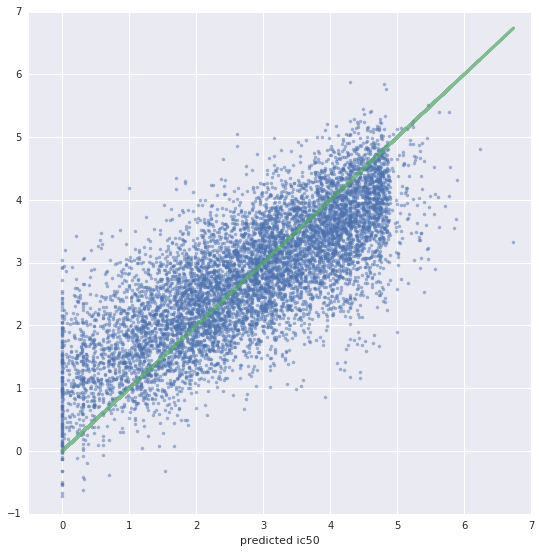

In [7]:
plt.figure(figsize=(9,9))
y_pred_test=bst.predict(dtest)
plt.plot(y_test,y_pred_test,'.',alpha=0.5)
plt.plot(y_test,y_test,lw=3,alpha=0.7)
plt.xlim(xmin=-0.5)
plt.xlabel('measured ic50')
plt.xlabel('predicted ic50')

from scipy.stats import pearsonr
print 'Correlation:',pearsonr(y_test,y_pred_test)[0]

### Error depending on the length of peptid

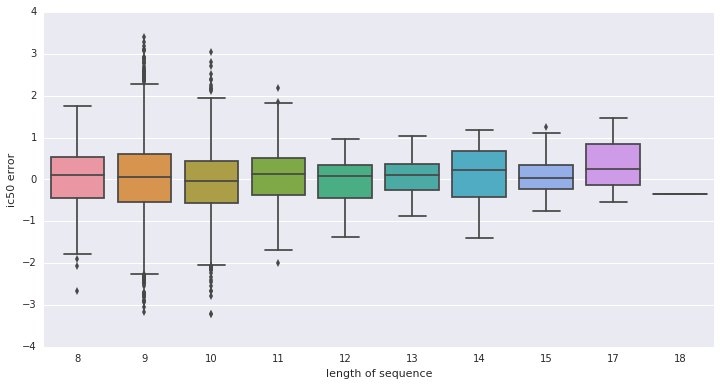

In [8]:
leng=X_test[:,-1]
plt.figure(figsize=(12,6))
sns.boxplot(leng,y_test-y_pred_test)
plt.xlabel('length of sequence')
dump=plt.ylabel('ic50 error')